## Feature Extraction Notebook
---

This notebook is used to extract features from the data. The audio is divided into windows of 1 second. The features extracted from each audio window are:
- MFCC (Mel-Frequency Cepstral Coefficients): 20 coefficients
- Chroma STFT: 1 coefficient
- RMS (Root Mean Square) Energy: 1 coefficient
- Spectral Centroid: 1 coefficient
- Spectral Bandwidth: 1 coefficient
- Spectral Roll-off: 1 coefficient
- Zero Crossing Rate: 1 coefficient
  
#### Findings:
- We have highly unbalanced classes in the dataset.

In [3]:
# import all the functions
from utils import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

# -------- tqdm DARK THEME --------

### Features Extraction

In [5]:
# set the paths to data
BASE_DIR = '../dataset/'
ARTIFACTS_DIR = BASE_DIR + 'artifacts/'
EXTRAHLS_DIR = BASE_DIR + 'extrahls/'
MURMURS_DIR = BASE_DIR + 'murmurs/'
NORMALS_DIR = BASE_DIR + 'normals/'
EXTRASTOLES_DIR = BASE_DIR + 'extrastoles/'

# paths to save the features
FEATURES_RAW_DIR = '../features/raw/'

In [6]:
# FEATURES EXTRACTION
paths = [ARTIFACTS_DIR, EXTRAHLS_DIR, MURMURS_DIR, NORMALS_DIR, EXTRASTOLES_DIR]
names = ['artifacts', 'extrahls', 'murmurs', 'normals', 'extrastoles']
window_length = 1
sample_rate = 'mix'
n_mfcc = 20
# melkwargs = {'n_fft': 2048, 'hop_length': 512, 'n_mels': 128}

for i, path in enumerate(paths):
     print(i)
     
     # Save the features to a file
     name = f'{names[i]}_{window_length}_{sample_rate}.npz'  ########## CHANGE THIS TO CHANGE THE NAME OF THE FILE
     
     if os.path.exists(FEATURES_RAW_DIR + name):
          print('The features have already been extracted')
     else:
          print(f'Extracting features from {path}')
          features = extract_features(path, label = i, frame_length = window_length, n_mfcc=n_mfcc)
          
          # Stack the features into a single tensor
          features = torch.cat(features, dim=0)
          print(f'The shape of the {path} features tensor is: {features.shape}')
          
          # if returns None continue
          if save_features(features, FEATURES_RAW_DIR, name) == None:
               continue
    
     print('Features extracted and saved')

          

0
The features have already been extracted
Features extracted and saved
1
The features have already been extracted
Features extracted and saved
2
The features have already been extracted
Features extracted and saved
3
The features have already been extracted
Features extracted and saved
4
The features have already been extracted
Features extracted and saved


### Show the features statistics

normals_1_mix.npz features   -   Label: 3.0
Max: 16976.08432112069, Min: -654.86279296875, Mean: 111.12140859068722, Std: 738.1790744503893      -       Shape: (2161, 26)

artifacts_1_mix.npz features   -   Label: 0.0
Max: 21160.455953663793, Min: -1131.369384765625, Mean: 483.97492510688136, Std: 1852.854843619321      -       Shape: (2000, 26)

extrastoles_1_mix.npz features   -   Label: 4.0
Max: 1057.6171875, Min: -309.2425537109375, Mean: 37.46883951805036, Std: 130.15941934366995      -       Shape: (247, 26)

extrahls_1_mix.npz features   -   Label: 1.0
Max: 18953.178879310344, Min: -674.0330810546875, Mean: 753.7483613723052, Std: 2587.231366594324      -       Shape: (124, 26)

murmurs_1_mix.npz features   -   Label: 2.0
Max: 13025.607825969828, Min: -574.7505493164062, Mean: 105.72155305406422, Std: 538.6539669046897      -       Shape: (1149, 26)



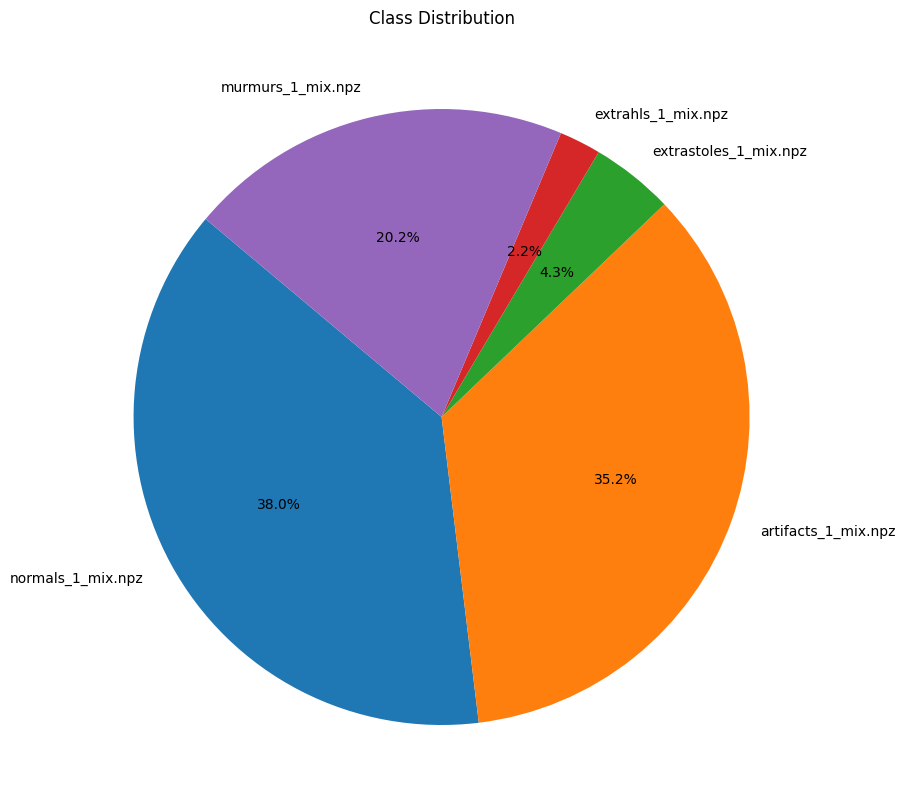

In [17]:
# basics statistics
names = os.listdir(FEATURES_RAW_DIR)
shapes = []
name_labels = {}

for name in names:
	features = np.load(FEATURES_RAW_DIR + name)['X']
	label = np.load(FEATURES_RAW_DIR + name)['y'][0]
	name_labels[name] = label
	max = features.max()
	min = features.min()
	mean = features.mean()
	std = features.std()
	print(f'{name} features   -   Label: {label}')
	print(f'Max: {max}, Min: {min}, Mean: {mean}, Std: {std}      -       Shape: {features.shape}\n')
	shapes.append(features.shape[0])
 


# use a cake chart to show the class distribution
plt.figure(figsize=(10, 10))
plt.pie(shapes, labels = name_labels.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.show()